# Conor Sayres
## Astro 597 - HW 1b

First import the packages we'll need for this work

In [1]:
using Plots
using DelimitedFiles

## The Data
First, lets read in the data for the mystery planet.  The timeseries is normalized to be zero at the first datapoint.

In [5]:
mp = readdlm("mystery_planet1.txt")
ts = mp[:,1];
radVel = mp[:,2];
vErr = mp[:,3];
tZero = ts[1];
ts = ts .- tZero; # normalize time to begin at zero

Here's a visualization of what we're starting with.  Note the crossing lines mean our dataset insn't sorted in time...but that turns out not to matter as we're going to be slicing and sorting everything next.

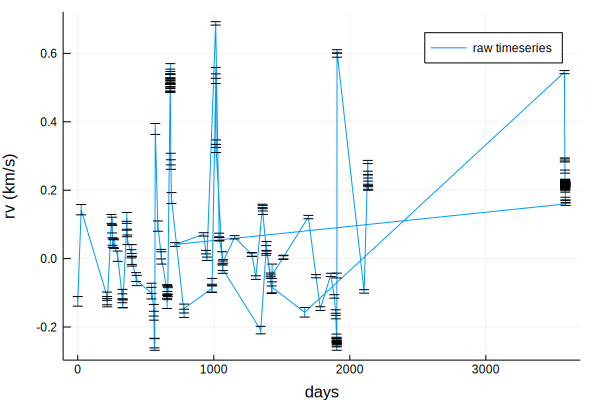

In [7]:
plot(ts, radVel, ylabel="rv (km/s)", xlabel="days", yerror=vErr, label="raw timeseries")

## Period solver
First write a method to detect the correct period for the mystery planet.  The 3 functions below will allow us to do this.

foldAndSortByTime takes a modTime (modulus time), and and 3 arrays a time vector, a radial velocity measurement vector, and an radial velocity sigma vector.  The function returns a folded (on time modulus) and sorted (in time) time vector, radial velocity vector and sigma vector.

In [2]:
function foldAndSortByTime(modTime, ts, radVel, vErr)
    # return a folded time series time, radVel, vErr
    ts = ts .% modTime # wrap the
    sortInds = sortperm(ts)
    ts = ts[sortInds]
    radVel = radVel[sortInds]
    vErr = vErr[sortInds]
    return ts, radVel, vErr
end

foldAndSortByTime (generic function with 1 method)

sumMinDist returns a metric that is the sum of the differences between subsequent radial velocity values weighted by the squared sigmas for each of those points.  This function is called in our period search, and when the metric is minimized, we've found a nicely fitting period for the dataset.

In [3]:
function sumMinDist(radVel, vErr)
    v1 = radVel[1:end-1]
    v2 = radVel[2:end]
    e1 = vErr[1:end-1]
    e2 = vErr[2:end]
    sigmas = e1.^2 .+ e2.^2
    dv = v2 .- v1
    # compute array of successive distances
    # scaled by the errors
    metric = sum(dv.^2 ./ sigmas) # minimize this
    return metric
end

sumMinDist (generic function with 1 method)

Finally here is the brute force period solver: periodSearch.  This function takes our three vectors (time, radial velocity, and radial velocity sigma), and creates a finely spaced array of fold times to try.  Period spacing is set to 0.001 days, and periods are searched for in the range of 0-1000 days (we can see from the plot above that this is a safe assumption, as we have many bumps in that amount of time).  The solver tests the sumMinDist metric at each folding, and returns resulting best found period, along with the sorted timeseries.   

In [8]:
function periodSearch(ts, radVel, vErr)
    # a brute force approach
    # returns: bestPeriod, folded time vector, velocity vector, error vector
    timeStep = .001 # days
    minTime = 0
    maxTime = 1000 # by visual inspection period is obviously less than this
    foldTimes = minTime:timeStep:maxTime
    minMetric = sumMinDist(radVel, vErr)
    bestP = -1 # period init
    bestT = ts # times
    bestV = radVel # velocities
    bestE = vErr # errors
    for (i, tryP) in enumerate(foldTimes)
        tryT, tryV, tryE = foldAndSortByTime(tryP, ts, radVel, vErr)
        metric = sumMinDist(tryV, tryE)
        # metrics[i] = metric
        if metric < minMetric
            minMetric = metric
            bestT = tryT
            bestV = tryV
            bestE = tryE
            bestP = tryP
        end
    end
    return bestP, bestT, bestV, bestE
end

periodSearch (generic function with 1 method)

Apply the period search to our dataset, and print our best found period:

In [11]:
period, tsFold, radVelFold, vErrFold = periodSearch(ts, radVel, vErr);
print("best period $period days\n")

best period 111.487 days


visualizing the period folded data:

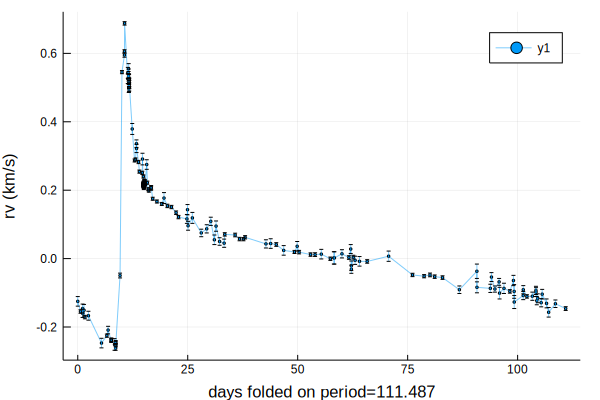

In [12]:
plot(tsFold, radVelFold, ylabel="rv (km/s)", xlabel="days folded on period=$period", markersize=1, markershape=:auto, line=:solid, linealpha=0.5, yerror=vErrFold)

## Orbit solver
Next task is to fully solve the orbit for parameters: period (P), time of periastron (t_p), longitude of periastron (omega), eccentricity (e), velocity semi-amplitude (K).  First we need a solver for Kepler's equation (carried over and slightly modified from HW1a).  The function will compute E given e and M.

In [13]:
function keplerSolve(e,M)
    # returns a E for a given e, M
    # ensure M is wrapped between 0 and 2*pi
    while M < 0
        M += 2*pi
    end
    while M > 2*pi
        M -= 2*pi
    end
    E_o = M + 0.85 * e * sign(sin(M))
    # exit tolerance
    epsilon = 1e-12
    maxIter = 1000
    iter = 1

    while iter < maxIter
        global E_next # eventual return value
        global E_error
        iter += 1
        der = 1 - e * cos(E_o)
        if der == 0
            der = 1e-16 # avoid zero division
        end
        E_next = E_o - (E_o - e * sin(E_o) - M) / der
        E_error = abs(E_o-E_next)
        if E_error < epsilon
            break # stop iteration we've converged
        end
        # update value and continue looping
        E_o = E_next
    end

    return E_o
end

keplerSolve (generic function with 1 method)

The next function is my full orbit solver.  It takes parameters e, P, and t_p.  It calls keplerSolve after constructing M from t_p and our raw timeseries.  f can be found from the resulting E (from keplerSolve) and e (a function input).  Next the routine will solve for h, c, and v_o which are linear parameters in the model for radial velocity 
$$ v_{rad} = hcos(f) + csin(f) + v_o $$
The solutions for h, c, and v_o can be found by computing $\chi^2$ derivatives with respect to each variable, and setting these all equal to 0.  This leads to a 3x3 Ax=b problem that can be solved easily using Julia's backslash operator.

The function ultimately returns a $\chi^2$ value, so we must call this function with a grid of  e, P, and t_p values and keep the set that minimizes $\chi^2$

In [15]:
# make these containers outside the function for reusability
Es = zeros(length(ts))
A = zeros(3,3)
b = zeros(3)

# inverse sigma squred is used allover the place so
# just compute it here
invSigma2 = vErr .^ -2

function solveOrbit(e, period, t_p)
    # returns a chi2, h, c, and v_o for the given inputs
    # Ms = 2*pi/period .* (ts .- t_p)
    # Ms = Ms .% (2*pi)

    Ms = 2*pi/period .* (ts .- t_p)

    # # wrap Ms to 0-2*pi
    # for ind in findall(Ms.<0)
    #     print("updating index $ind\n")
    #     Ms[ind] = Ms[ind] + 2*pi
    # end


    # use keplers eqn solver to get the Es
    for (ii, M) in enumerate(Ms)
        # ensure M is wrapped correctly between 0-2pi
        ### cut and past in slover here to increase speed?
        Es[ii] = keplerSolve(e,M)
    end
    fs = 2 * atan.( ((1+e)/(1-e))^0.5 * tan.(Es/2) )
    # linear solver for h, c and v_0
    # precompute some stuff
    cosfs = cos.(fs) # compute once
    sinfs = sin.(fs) # compute once
    sincosfs = cosfs .* sinfs
    cos2fs = cosfs .^ 2
    sin2fs = sinfs .^ 2

    A[1,1] = sum(invSigma2 .* cos2fs )
    A[1,2] = sum(invSigma2 .* sincosfs)
    A[1,3] = sum(invSigma2 .* cosfs)

    A[2,1] = A[1,2]
    A[2,2] = sum(invSigma2 .* sin2fs)
    A[2,3] = sum(invSigma2 .* sinfs)

    A[3,1] = A[1,3]
    A[3,2] = A[2,3]
    A[3,3] = sum(invSigma2)

    b[1] = sum(invSigma2 .* radVel .* cosfs)
    b[2] = sum(invSigma2 .* radVel .* sinfs)
    b[3] = sum(invSigma2 .* radVel)

    h,c,v_o = A\b

    vModel = h .* cosfs .+ c .* sinfs .+ v_o

    chi2 = sum( (radVel .- vModel).^2 .* invSigma2 )
    return chi2, h, c, v_o
end

solveOrbit (generic function with 1 method)

Finally, lets search for the best inputs.  To do this I construct a grid of eccentricities and t_p values and feed them into the orbitSolver, fixing the period to be what we discovered earlier.  The parameters that minimize the $\chi^2$ value are our solution.

In [16]:
# brute force solve for e, and tp
eRange = 0.7:.01:0.99
tpRange = 0:0.1:period
bestChi2 = 1e16 # initialize to a big number
best_e = 0
best_tp = 0
best_h = 0
best_c = 0
best_vo = 0
for e in eRange
    for t_p in tpRange
        global bestChi2
        chi2, h, c, v_o = solveOrbit(e, period, t_p)
        if chi2 < bestChi2
            global best_e
            global best_tp
            global best_h
            global best_c
            global best_vo
            bestChi2 = chi2
            best_e = e
            best_tp = t_p
            best_h = h
            best_c = c
            best_vo = v_o
        end
    end
end

print("brute force e=$best_e and t_p=$best_tp\n")

brute force e=0.93 and t_p=10.0


with a little math, we can translate h, c, and v_o into gamma, K, and omega, then print our fully solved for orbital parameters

In [17]:
# convert h, c, v_o to gamma, K, omega
gamma = best_vo - best_e * best_h # m/s
K = sqrt(best_h^2+best_c^2) # m/s
omega = acos(best_h / K) * 360 / (2*pi) # degrees
print("period = $period days\ne = $best_e\nt_p = $best_tp days after tZero = $tZero (first point in timeseries)\ngamma = $gamma km/s\nK = $K km/s\nomega = $omega degrees\n")

period = 111.487 days
e = 0.93
t_p = 10.0 days after tZero = 2.451293846e6 (first point in timeseries)
gamma = -0.010258985033530316 km/s
K = 0.46498355224177684 km/s
omega = 56.50230571526069 degrees


Next, I'll plot my modeled orbit over the Period folded raw dataset:

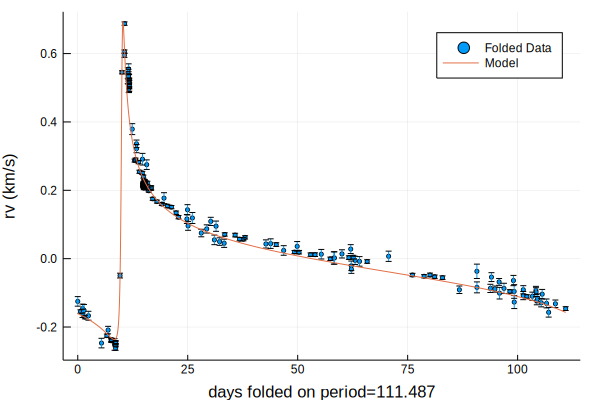

In [18]:
function plotOrbitSoln(e, P, t_p, h, c, v_o)
    tMax = maximum(tsFold)
    tMin = minimum(tsFold)
    tPts = tMin:0.01:tMax
    Ms = 2*pi/P .* (tPts .- t_p)
    Es = zeros(length(tPts))
    # use keplers eqn solver to get the Es
    for (ii, M) in enumerate(Ms)
        Es[ii] = keplerSolve(e,M)
    end
    fs = 2 * atan.( ((1+e)/(1-e))^0.5 * tan.(Es/2) )
    vModel = h .* cos.(fs) .+ c .* sin.(fs) .+ v_o
    plot(tsFold, radVelFold, ylabel="rv (km/s)", xlabel="days folded on period=$P", markersize=2, seriestype=:scatter, yerror=vErrFold, label="Folded Data")
    plot!(tPts, vModel, line=:solid, label="Model")
end

plotOrbitSoln(best_e, period, best_tp, best_h, best_c, best_vo)

## Random Thoughts
After a little sleuthing in the exoplanet database online, I think this planet is HD 80606 b.  My fits for e and P are great!  My fits for K, gamma, and omega are not so great.  Some of this is due to the rescaling of the RV dataset as provided.  However, at least omega should be unaffected by this.  I wasn't able to compute uncertainties on these values, but my guess is that the gamma uncertainty is high due to the geometry of the system, so perhaps the true solution does lie within my (uncomputed!) uncertainties...

My first attempts at solving this were using the Optim package in Julia, with the default nonlinear solver 'optimize'.  The solutions were problematic, in part due to the fact that e and t_p are treated as unconstrained variables.  Often I would find the solver tyring negative values of e, which of course blew solveOrbit up in flames.  In the end I resulted to using a grid of values for e and t_p to search out the minimum $\chi^2$, as I was able to constrain them roughly how I wanted.  I think there are ways of running constrained optimizations in optim but I found the documetation tough to wade through...in the end a grid of 2 variables isn't so computationally rough.